In [1]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from keras.datasets import mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras import regularizers
from keras.regularizers import l2
from keras import backend as K
from keras.models import load_model
from keras.utils import to_categorical
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from numpy import dstack
from os import makedirs
import itertools
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

Using TensorFlow backend.


In [2]:
df=pd.read_csv('ildp2.csv')

In [3]:
df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [4]:
df.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

In [5]:
df['Albumin_and_Globulin_Ratio'].mean()
df=df.replace(to_replace = np.nan, value = 0.95)  

Number of patients diagnosed with liver disease (denoted by "1"):  416
Number of patients not diagnosed with liver disease (denoted by "2"):  167


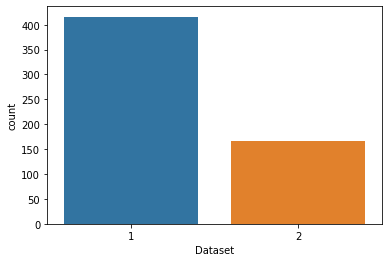

In [6]:
sns.countplot(data=df, x = 'Dataset', label='Count')

Yes,No = df['Dataset'].value_counts()
print('Number of patients diagnosed with liver disease (denoted by "1"): ',Yes)
print('Number of patients not diagnosed with liver disease (denoted by "2"): ',No)

Number of patients that are male:  441
Number of patients that are female:  142


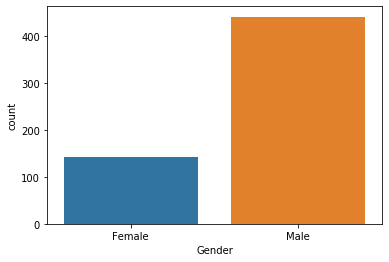

In [7]:
sns.countplot(data=df, x = 'Gender', label='Count')

M, F = df['Gender'].value_counts()
print('Number of patients that are male: ',M)
print('Number of patients that are female: ',F)

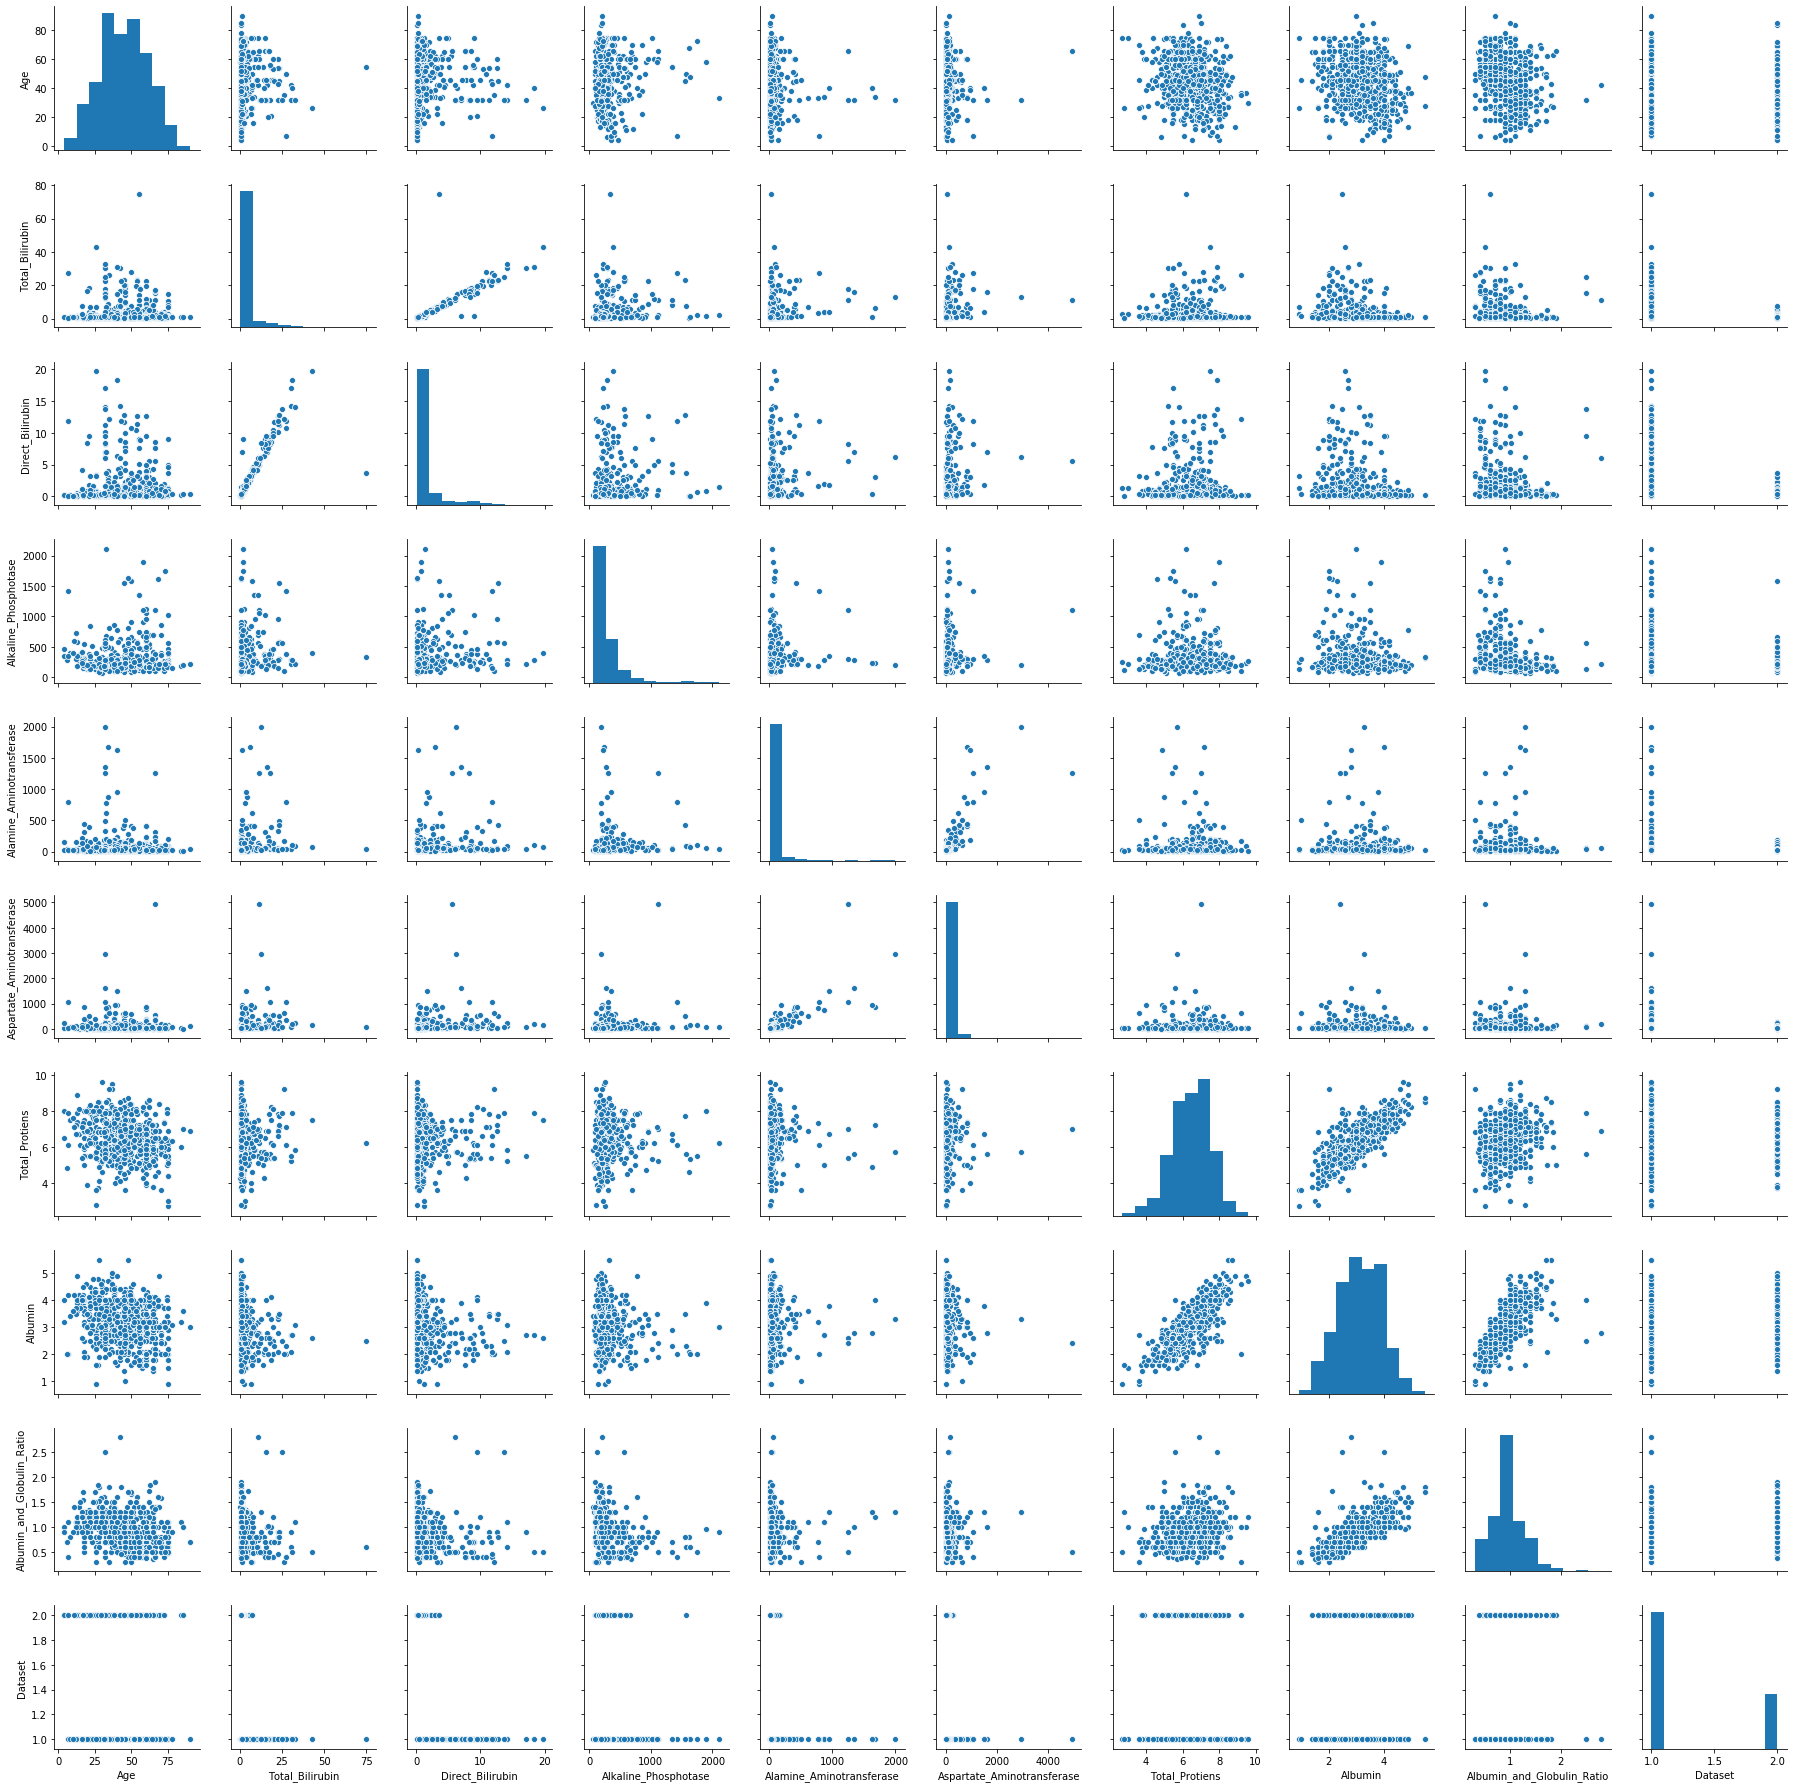

In [8]:
sns.pairplot(df)
plt.show()

In [9]:
cleanup_nums = {"Gender":     {"Female": 0, "Male": 1}}
df.replace(cleanup_nums, inplace=True)

In [10]:
corr_matrix=df.corr()
corr_matrix['Dataset'].sort_values(ascending=False)

Dataset                       1.000000
Albumin_and_Globulin_Ratio    0.162349
Albumin                       0.161388
Total_Protiens                0.035008
Gender                       -0.082416
Age                          -0.137351
Aspartate_Aminotransferase   -0.151934
Alamine_Aminotransferase     -0.163416
Alkaline_Phosphotase         -0.184866
Total_Bilirubin              -0.220208
Direct_Bilirubin             -0.246046
Name: Dataset, dtype: float64

In [11]:
df['Alamine_Aminotransferase'].value_counts()

25      25
20      23
22      18
18      17
28      17
        ..
71       1
75       1
76       1
78       1
2000     1
Name: Alamine_Aminotransferase, Length: 152, dtype: int64

In [12]:
%matplotlib inline 
#from pandas.plotting import scatter_matrix
#attributes=["Dataset","Albumin_and_Globulin_Ratio","Total_Protiens","Age","Aspartate_Aminotransferase","Alamine_Aminotransferase","Alkaline_Phosphotase","Total_Bilirubin","Direct_Bilirubin"]
#scatter_matrix( df[attributes],figsize=(25,25))

In [13]:
from sklearn.model_selection import train_test_split
train_set,test_set=train_test_split(df,test_size=0.3,random_state=42)

In [14]:
print(f"Rows in train set:{len(train_set)}\nRows in test set:{len(test_set)}\n")

Rows in train set:408
Rows in test set:175



In [15]:
train_set_labels=train_set['Dataset'].copy()
train_set=train_set.drop('Dataset',axis=1).copy()
test_set_labels=test_set['Dataset'].copy()
test_set=test_set.drop('Dataset',axis=1).copy()

x = train_set.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
train_set = pd.DataFrame(x_scaled)

y = test_set.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
y_scaled = min_max_scaler.fit_transform(y)
test_set = pd.DataFrame(y_scaled)

In [16]:
X_train = train_set.astype('float32')
X_test = test_set.astype('float32')
print("Input data shape",train_set.shape)

Input data shape (408, 10)


In [17]:
train_set_labels

519    1
536    1
531    1
380    1
550    1
      ..
71     1
106    2
270    1
435    2
102    1
Name: Dataset, Length: 408, dtype: int64

# ANN HYPERPARAMETERS

In [18]:
epochs = 120
batch_size = 128
verbose = 0
classes = 3

optimizer = Adam()
hidden = 128
validation_split = 0.1
dropout = 0.1

In [19]:
Y_train = np_utils.to_categorical(train_set_labels, classes)
Y_test = np_utils.to_categorical(test_set_labels, classes)

# BUILDING OUR ANN

In [20]:
def fit_model(X_train,Y_train):
    def l1_reg(weight_matrix):
        return 0.2 * K.sum(K.abs(weight_matrix))

    model = Sequential()
    model.add(Dense(hidden, input_shape=(X_train.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(hidden))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(classes))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(X_train, Y_train, batch_size=batch_size, verbose = verbose,epochs=epochs, validation_split=validation_split)
    return model, history

In [21]:
if not os.path.isdir("./models/"):
    makedirs('models')

In [22]:
n_members =10
for i in range(n_members):
    model,history = fit_model(X_train,Y_train)
    filename = 'models/model_' + str(i + 1) + '.h5'
    model.save(filename)
    print('Saved %s' % filename)
model.summary()

Saved models/model_1.h5
Saved models/model_2.h5
Saved models/model_3.h5
Saved models/model_4.h5
Saved models/model_5.h5
Saved models/model_6.h5
Saved models/model_7.h5
Saved models/model_8.h5
Saved models/model_9.h5
Saved models/model_10.h5
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_47 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_49 (Dense)             (None, 128)               16512     
__________

# TRAINING

In [23]:
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        filename = 'models/model_' + str(i + 1) + '.h5'
        model = load_model(filename)
        all_models.append(model)
        print('loaded %s' % filename)
    return all_models

members = load_all_models(n_members)
print('Loaded %d models' % len(members))

for model in members:
    score = model.evaluate(X_test, Y_test, verbose = verbose)
    print('Accuracy is {:.2f}%'.format((score[1])*100))

loaded models/model_1.h5
loaded models/model_2.h5
loaded models/model_3.h5
loaded models/model_4.h5
loaded models/model_5.h5
loaded models/model_6.h5
loaded models/model_7.h5
loaded models/model_8.h5
loaded models/model_9.h5
loaded models/model_10.h5
Loaded 10 models
Accuracy is 73.14%
Accuracy is 73.14%
Accuracy is 73.14%
Accuracy is 73.14%
Accuracy is 73.14%
Accuracy is 73.14%
Accuracy is 73.14%
Accuracy is 73.14%
Accuracy is 73.14%
Accuracy is 73.14%


# LOGISTIC REGRESSION

Logistic Regression Training Score: 
 71.32
Logistic Regression Test Score: 
 72.57
Coefficient: 
 [[-0.00799647 -0.07203949 -0.00672174 -0.33353205 -0.00091527 -0.01077578
  -0.00242473 -0.32818983  0.72303761 -0.11679372]]
Intercept: 
 [0.60373041]
Accuracy: 
 0.7257142857142858
Confusion Matrix: 
 [[118  10]
 [ 38   9]]
Classification Report: 
               precision    recall  f1-score   support

           1       0.76      0.92      0.83       128
           2       0.47      0.19      0.27        47

    accuracy                           0.73       175
   macro avg       0.62      0.56      0.55       175
weighted avg       0.68      0.73      0.68       175



/Users/pawelpratyush/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


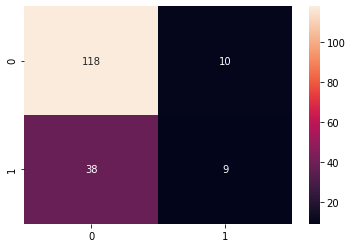

In [24]:
logreg = LogisticRegression()
# Train the model using the training sets and check score
logreg.fit(train_set, train_set_labels)
#Predict Output
log_predicted= logreg.predict(test_set)
logreg_score = round(logreg.score(train_set, train_set_labels) * 100, 2)
logreg_score_test = round(logreg.score(test_set, test_set_labels) * 100, 2)
#Equation coefficient and Intercept
print('Logistic Regression Training Score: \n', logreg_score)
print('Logistic Regression Test Score: \n', logreg_score_test)
print('Coefficient: \n', logreg.coef_)
print('Intercept: \n', logreg.intercept_)
print('Accuracy: \n', accuracy_score(test_set_labels,log_predicted))
print('Confusion Matrix: \n', confusion_matrix(test_set_labels,log_predicted))
print('Classification Report: \n', classification_report(test_set_labels,log_predicted))

sns.heatmap(confusion_matrix(test_set_labels,log_predicted),annot=True,fmt="d")

# GUASSIAN NAIVE BAYES

Gaussian Score: 
 54.17
Gaussian Test Score: 
 57.14
Accuracy: 
 0.5714285714285714
[[54 74]
 [ 1 46]]
              precision    recall  f1-score   support

           1       0.98      0.42      0.59       128
           2       0.38      0.98      0.55        47

    accuracy                           0.57       175
   macro avg       0.68      0.70      0.57       175
weighted avg       0.82      0.57      0.58       175



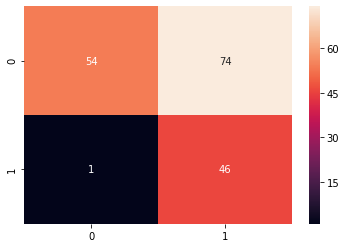

In [25]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(train_set,train_set_labels)
#Predict Output
gauss_predicted = gaussian.predict(test_set)
gauss_score = round(gaussian.score(train_set, train_set_labels) * 100, 2)
gauss_score_test = round(gaussian.score(test_set, test_set_labels) * 100, 2)
print('Gaussian Score: \n', gauss_score)
print('Gaussian Test Score: \n', gauss_score_test)
print('Accuracy: \n', accuracy_score(test_set_labels, gauss_predicted))
print(confusion_matrix(test_set_labels,gauss_predicted))
print(classification_report(test_set_labels,gauss_predicted))

sns.heatmap(confusion_matrix(test_set_labels,gauss_predicted),annot=True,fmt="d")

# RANDOM FOREST

Random Forest Score: 
 100.0
Random Forest Test Score: 
 70.86
Accuracy: 
 0.7085714285714285
[[107  21]
 [ 30  17]]
              precision    recall  f1-score   support

           1       0.78      0.84      0.81       128
           2       0.45      0.36      0.40        47

    accuracy                           0.71       175
   macro avg       0.61      0.60      0.60       175
weighted avg       0.69      0.71      0.70       175



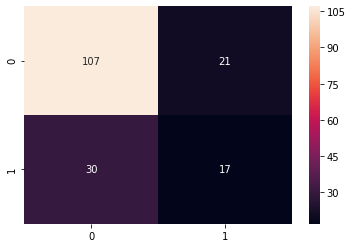

In [26]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(train_set, train_set_labels)
#Predict Output
rf_predicted = random_forest.predict(test_set)

random_forest_score = round(random_forest.score(train_set, train_set_labels) * 100, 2)
random_forest_score_test = round(random_forest.score(test_set, test_set_labels) * 100, 2)
print('Random Forest Score: \n', random_forest_score)
print('Random Forest Test Score: \n', random_forest_score_test)
print('Accuracy: \n', accuracy_score(test_set_labels,rf_predicted))
print(confusion_matrix(test_set_labels,rf_predicted))
print(classification_report(test_set_labels,rf_predicted))
sns.heatmap(confusion_matrix(test_set_labels,rf_predicted),annot=True,fmt="d")

# MLP CLASSIFIER

MLP classifier Score: 
 78.68
MLP classifier Test Score: 
 66.86
Accuracy: 
 0.6685714285714286
[[96 32]
 [26 21]]
              precision    recall  f1-score   support

           1       0.79      0.75      0.77       128
           2       0.40      0.45      0.42        47

    accuracy                           0.67       175
   macro avg       0.59      0.60      0.59       175
weighted avg       0.68      0.67      0.67       175



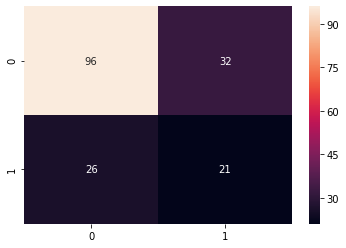

In [27]:
#MLP classifier
clf = MLPClassifier(hidden_layer_sizes=(50,50,50),activation='tanh', max_iter=500, alpha=1e-4,
                     solver='lbfgs', verbose=10,  random_state=21,tol=0.000000001)
clf.fit(train_set,train_set_labels)
#Predict Output 
y_pred = clf.predict(test_set)
mlp_score = round(clf.score(train_set, train_set_labels) * 100, 2)
mlp_score_test = round(clf.score(test_set, test_set_labels) * 100, 2)
print('MLP classifier Score: \n', mlp_score)
print('MLP classifier Test Score: \n', mlp_score_test)
print('Accuracy: \n', accuracy_score(test_set_labels,y_pred))
print(confusion_matrix(test_set_labels,y_pred))
print(classification_report(test_set_labels,y_pred))
sns.heatmap(confusion_matrix(test_set_labels,y_pred),annot=True,fmt="d")

# OUR ENSEMBLE MODEL

In [28]:
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
        # make prediction
        ystack = model.predict(inputX)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = ystack
        else:
            stackX = dstack((stackX, ystack))
    # flatten predictions to [rows, members x probabilities]
    nsamples, nx, ny = stackX.shape
    stackX = stackX.reshape((nsamples,nx*ny))
    return stackX

def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = RandomForestClassifier(n_estimators=1000)
    model.fit(stackedX, inputy)
    return model

def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    ystack = model.predict(stackedX)
    return ystack

# fit stacked model using the ensemble
model = fit_stacked_model(members, X_test, Y_test)

In [29]:
ystack = stacked_prediction(members, model, X_test)
acc = accuracy_score(Y_test, ystack)
print('Test Accuracy: %.3f' % acc)

Test Accuracy: 1.000


In [30]:
print(classification_report(Y_test, ystack))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00       128
           2       1.00      1.00      1.00        47

   micro avg       1.00      1.00      1.00       175
   macro avg       0.67      0.67      0.67       175
weighted avg       1.00      1.00      1.00       175
 samples avg       1.00      1.00      1.00       175



/Users/pawelpratyush/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/pawelpratyush/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


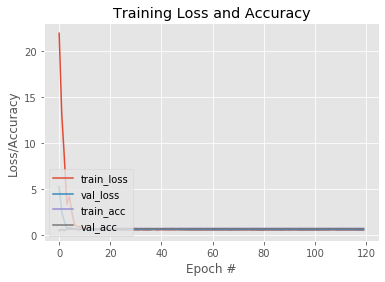

In [31]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")